<a href="https://colab.research.google.com/github/zhifeichen097/CIFAR_10_Classification/blob/main/cifar_10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependency

In [22]:
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn

## Data Loader

In [2]:
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory): 
            # The train data
            if 'data_batch' in filename:
                print('Processing file: %s' % filename)
                
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train: 
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the propper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return (train_x, train_y), (test_x, test_y)

In [3]:
(x_train, y_train), (x_test, y_test) = unpickle_all_data('/content/drive/MyDrive/Colab Notebooks/resnet/data')

Processing file: data_batch_1
Processing file: data_batch_2
Processing file: data_batch_3
Processing file: data_batch_4
Processing file: data_batch_5
Handing file: test_batch


In [4]:
class CIFAR10_Loader(Dataset):
      def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
        self.img_shape = data.shape

      def __getitem__(self, index):
        img = Image.fromarray(self.data[index])
        label = self.label[index]
        if self.transform:
            img = self.transform(img)
        else:
            img_to_tensor = transforms.ToTensor()
            img = img_to_tensor(img)
        return img, label
      
      def __len__(self):
        return len(self.data)

def normalize_data(data):
  mean = data.mean(axis = (0, 1, 2)) / 255.0
  std = data.std(axis = (0, 1, 2)) / 255.0
  normalize = transforms.Normalize(mean, std)
  return normalize

### data augmentation ###
train_transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),      
    transforms.RandomCrop((32, 32)),   
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_data(x_train)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_data(x_train)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_data(x_test)
])



In [5]:
# split the validation set out
from sklearn.model_selection import train_test_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

train_set = CIFAR10_Loader(data=x_train_split, label=y_train_split, transform=train_transform_aug)
val_set = CIFAR10_Loader(data=x_val_split, label=y_val_split, transform=val_transform)
test_set = CIFAR10_Loader(data=x_test, label=y_test, transform=test_transform)

#print(len(train_set))

train_loader = DataLoader(dataset=train_set,batch_size=64, shuffle=True, num_workers=1)
val_loader = DataLoader(dataset=val_set,batch_size=64, shuffle=False, num_workers=1)
test_loader = DataLoader(dataset=test_set,batch_size=64, shuffle=False, num_workers=1)

In [6]:
## test ##
imgs, lbls = iter(train_loader).next()
print(imgs.shape)

torch.Size([64, 3, 32, 32])


## ResNet Architecture


In [15]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(BasicBlock, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.bn1(self.conv1(x)))
      x = self.bn2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_channel, out_channel, i_downsample=None, stride=1):
    super(BottleNeck, self).__init__()

    self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channel)
        
    self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channel)
        
    self.conv3 = nn.Conv2d(out_channel, out_channel*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)

    self.i_downsample = i_downsample
    self.stride = stride
    self.relu = nn.ReLU()

  def forward(self, x):

    identity = x.clone()

    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))

    if self.i_downsample:
      identity = self.i_downsample(identity)
    
    x += identity
    x = self.relu(x)
    return x 

class ResNet(nn.Module):
  def __init__(self, basic_block, layer_list, num_classes, num_channels=3):
    super(ResNet, self).__init__()

    self.in_channels = 64

    self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self.make_layer(basic_block, layer_list[0], out_channel=64)
    self.layer2 = self.make_layer(basic_block, layer_list[1], out_channel=128, stride=2)
    self.layer3 = self.make_layer(basic_block, layer_list[2], out_channel=256, stride=2)
    self.layer4 = self.make_layer(basic_block, layer_list[3], out_channel=512, stride=2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512*basic_block.expansion, num_classes)

  def make_layer(self, basic_block, num_layers, out_channel, stride=1):
    ii_downsample = None
    layers = []
        
    if stride != 1 or self.in_channels != out_channel*basic_block.expansion:
        ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channel*basic_block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channel*basic_block.expansion)
        )
    
    layers.append(basic_block(self.in_channels, out_channel, i_downsample=ii_downsample, stride=stride))
    self.in_channels = out_channel*basic_block.expansion
        
    for i in range(num_layers-1):
      layers.append(basic_block(self.in_channels, out_channel))
            
    return nn.Sequential(*layers)
    
  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.max_pool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #print(x.shape)
    x = self.layer4(x)
        
    x = self.avg_pool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

In [16]:
def ResNet50(num_classes, channels=3):
    return ResNet(BottleNeck, [3,4,6,3], num_classes, channels)

## test ##
net = ResNet50(10)
y = net(torch.randn(64, 3, 32, 32))
print(y.shape)

torch.Size([64, 10])


## Training

In [17]:
import torch.optim as optim
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [25]:
EPOCHS = 200
total_train_loss = []
total_val_loss = []
score_list = []
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    correct = 0
    total = 0
    for i, inp in enumerate(train_loader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    total_train_loss.append(avg_loss)
    scheduler.step(avg_loss)

  #<---------------Validation Loop---------------------->
    with torch.no_grad():
      for i, inp in enumerate(val_loader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        #running_loss += loss.item()
    avg_loss = sum(losses)/len(losses)
    total_val_loss.append(avg_loss)

  #<---------------Test Loop---------------------->
    for data in test_loader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    score_list.append(100*(correct/total))
    print('Accuracy test images: ', 100*(correct/total), '%')
            
print('Training Done')

Loss [1, 100](epoch, minibatch):  1.5971621894836425
Loss [1, 200](epoch, minibatch):  1.4941417062282563
Loss [1, 300](epoch, minibatch):  1.4611489832401277
Loss [1, 400](epoch, minibatch):  1.4703956139087677
Loss [1, 500](epoch, minibatch):  1.4153948521614075
Loss [1, 600](epoch, minibatch):  1.4038525915145874
Accuracy test images:  53.339999999999996 %
Loss [2, 100](epoch, minibatch):  1.3879529291391373
Loss [2, 200](epoch, minibatch):  1.348981665968895
Loss [2, 300](epoch, minibatch):  1.3840288698673249
Loss [2, 400](epoch, minibatch):  1.3367592334747314
Loss [2, 500](epoch, minibatch):  1.3391355860233307
Loss [2, 600](epoch, minibatch):  1.3631474423408507
Accuracy test images:  54.22 %
Loss [3, 100](epoch, minibatch):  1.4311468648910521
Loss [3, 200](epoch, minibatch):  1.3661815655231475
Loss [3, 300](epoch, minibatch):  1.4356723833084106
Loss [3, 400](epoch, minibatch):  1.3662859225273132
Loss [3, 500](epoch, minibatch):  1.471145043373108
Loss [3, 600](epoch, minib

<Figure size 432x288 with 0 Axes>

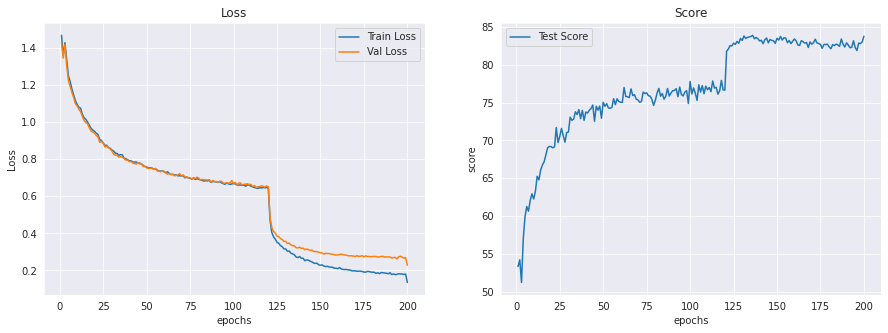

In [26]:
import seaborn as sns
num_epochs = 200
plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,num_epochs+1), y=total_val_loss, label="Val Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,num_epochs+1), y=score_list, label="Test Score")
plt.title("Score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()